In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
from scipy import optimize

# Extract all parameters

In [8]:
def extract_A(A_inf_tmp, I_s_vec, A_thresh):
    
    A_sign = np.sign(A_inf_tmp[0]-A_thresh)   
    change_idx = np.where(np.diff(A_sign)!=0)[0]
    lower_A = A_inf_tmp[0][change_idx]
    upper_A = A_inf_tmp[0][change_idx+1]
    lower_I = I_s_vec[change_idx]
    upper_I = I_s_vec[change_idx+1]
    
    m = (upper_A-lower_A)/(upper_I-lower_I) # linear interpolation between the two points on either side of the crossing 
    I_thresh = (1/m)*(A_thresh - lower_A) + lower_I
    
    return I_thresh


def extract_c(cv_tmp, cv_passive, I_s_vec):
    
    max_idx = np.where(cv_tmp[0]==np.max(cv_tmp[0]))[0]
    
    c = cv_tmp[0][max_idx] - cv_passive[0][max_idx]
    max_cv_I = I_s_vec[max_idx]
    
    return c, max_cv_I

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0 -k1*x0, lambda x:k2*x + y0-k2*x0])

def extract_g(A_inf_tmp, I_s_vec, piecewise_linear):
    
    x = I_s_vec
    y = np.log(A_inf_tmp[0])
    p , e = optimize.curve_fit(piecewise_linear, x, y, [1.25, 3, 1.5, 0.5])
    
    rate = p[2]
    transition = p[0]
    lift = p[1] - p[2]*p[0]
    
    return rate, transition, lift


def load_kernel_data(param1_key, param1_vec, param2_key, param2_vec):
    
    data_folder = 'kernel_change_data'
    
    a = np.zeros((len(param1_vec), len(param2_vec)))
    c = np.zeros((len(param1_vec), len(param2_vec)))
    c_I = np.zeros((len(param1_vec), len(param2_vec)))
    g = np.zeros((len(param1_vec), len(param2_vec)))
    g_I = np.zeros((len(param1_vec), len(param2_vec)))
    g_A0 = np.zeros((len(param1_vec), len(param2_vec)))
    
    I_s_vec = np.linspace(0, 5, 31)
    for i, param1 in enumerate(param1_vec):
        for j, param2 in enumerate(param2_vec):

            with open('../data/kernel_change_data/A_inf_' + param1_key + '_' + str(param1) + param2_key + '_' + str(param2) + '_change.pkl', 'rb') as f:
                A_inf_tmp = pickle.load(f)
                
            with open('../data/kernel_change_data/cv_' + param1_key + '_' + str(param1) + param2_key + '_' + str(param2) + '_change.pkl', 'rb') as f:
                cv_tmp = pickle.load(f)
            

            with open('../data/kernel_change_data/A_inf_' + param1_key + '_' + str(param1) + param2_key + '_' + str(param2) + '_change_passive.pkl', 'rb') as f:
                A_inf_passive = pickle.load(f)
                
            with open('../data/kernel_change_data/cv' + param1_key + '_' + str(param1) + param2_key + '_' + str(param2) + '_change_passive.pkl', 'rb') as f:
                cv_passive = pickle.load(f)
                
            A_thresh = 80
            I_thresh_active = extract_A(A_inf_tmp, I_s_vec, A_thresh)
            I_thresh_passive = extract_A(A_inf_passive, I_s_vec, A_thresh)
            
            a[i, j] = I_thresh_passive - I_thresh_active
            
            c[i, j], c_I[i, j] = extract_c(cv_tmp, cv_passive, I_s_vec)
            
            g[i, j], g_I[i, j], g_A0[i, j] = extract_g(A_inf_tmp, I_s_vec, piecewise_linear)
            
    return a, c, c_I, g, g_I, g_A0

In [9]:
D_vec = np.linspace(0, 5, 30)
delta_D_vec = np.linspace(1, 15, 30)
a, c, c_I, g, g_I, g_A0 = load_kernel_data(param1_key='D', param1_vec=D_vec, param2_key='delta_D', param2_vec=delta_D_vec)

In [17]:
def plot_parameter(param_data, param_name, filename):

    plt.figure(figsize=(2, 1.5))
    ax = sns.heatmap(param_data, cmap='Blues')
    ax.invert_yaxis()
    plt.title(f'${param_name}$')

    loc = [0, 29/2, 29]
    plt.xticks(loc, [0, 75, 150], rotation=0)
    plt.yticks(loc, [0, 2.5, 5], rotation=0)

    plt.xlabel('$\Delta_{d}$ [ms]')
    plt.ylabel('$D$')
    plt.tight_layout()

    plt.savefig('../results/'+ filename + '.svg')
    
    return

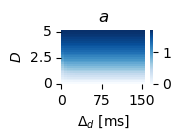

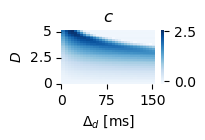

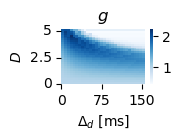

In [16]:
plot_parameter(param_data=a, param_name='a', filename='a_parameter')
plot_parameter(param_data=c, param_name='c', filename='c_parameter')
plot_parameter(param_data=g, param_name='g', filename='g_parameter')